In [3]:
import os
import numpy as np
from glob import glob
import numpy as np
#import keras
from keras.utils import np_utils
from sklearn.datasets import load_files
from glob import glob
def load_dataset(path):
    data = load_files(path)
    fruit_files = np.array(data['filenames'])
    fruit_targets = np_utils.to_categorical(np.array(data['target']),81)
    return fruit_files,fruit_targets

files,targets = load_dataset("../ligia/workspace/python/fruits-360/Training/")
train_files,train_targets = files[:30269],targets[:30269]
#os.listdir("../ligia/workspace/python/fruits-360/Training")
valid_files,valid_targets = files[30269:],targets[30269:]
test_files, test_targets = load_dataset('../ligia/workspace/python/fruits-360/Test/')
fruit_categories = [item[55:] for item in sorted(glob("../ligia/workspace/python/fruits-360/Training/*"))]
print('There are %d total fruit categories.' % len(fruit_categories))
print('There are %s total fruit images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training fruit images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test fruit images.'% len(test_files))
#print('There are %d multiple test fruit images.'% len(multiple_test_files))

There are 81 total fruit categories.
There are 55199 total fruit images.

There are 30269 training fruit images.
There are 11053 validation dog images.
There are 13877 test fruit images.


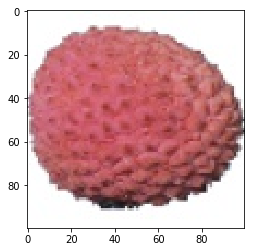

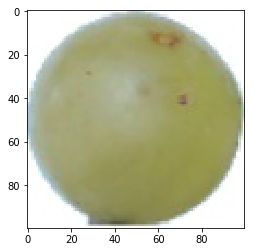

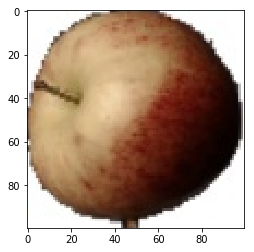

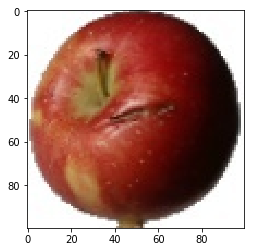

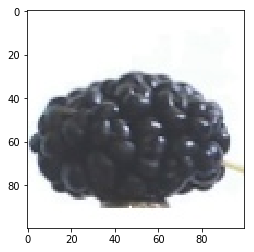

In [4]:
import cv2
import matplotlib.pyplot as plt                        
%matplotlib inline    
count = 0
for i in train_files:
    print(i[83:90])
    img = cv2.imread(i)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    count += 1
    if count == 5:
        break

In [5]:
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(100,100))
    x = image.img_to_array(img)
    return np.expand_dims(x,axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [6]:
import keras
from keras.applications.xception import Xception, preprocess_in
put
train_data = preprocess_input(paths_to_tensor(train_files))
valid_data = preprocess_input(paths_to_tensor(valid_files))
test_data = preprocess_input(paths_to_tensor(test_files))
#multiple_test_data = preprocess_input(paths_to_tensor(multiple_test_files))
weights = "../input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_xception = keras.applications.xception.Xception(include_top=False, weights=weights)

100%|██████████| 30269/30269 [10:39<00:00, 47.30it/s]  


MemoryError: 

In [ ]:
np.savez("FruitFeaturesXception.npz",train=model_xception.predict(train_data),valid=model_xception.predict(valid_data),\
         test=model_xception.predict(test_data))

In [ ]:
import numpy as np
bottleneck_features = np.load("FruitFeaturesXception.npz")
train_xception = bottleneck_features['train']
valid_xception = bottleneck_features['valid']
test_xception = bottleneck_features['test']

In [ ]:
from keras.callbacks import ModelCheckpoint  
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
my_model = Sequential()
my_model.add(GlobalAveragePooling2D(input_shape=train_xception.shape[1:]))
my_model.add(Dense(1032, activation='relu'))
my_model.add(Dropout(0.2))
my_model.add(Dense(512, activation='relu'))
my_model.add(Dropout(0.2))
my_model.add(Dense(256, activation='relu'))
my_model.add(Dropout(0.2))
my_model.add(Dense(81, activation='softmax'))

my_model.summary()

In [ ]:
my_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 50

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='weights.best.xception.hdf5', 
                               verbose=1, save_best_only=True)

In [ ]:
my_model.fit(train_xception, train_targets, 
          validation_data=(valid_xception, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

In [ ]:
my_model.load_weights('weights.best.xception.hdf5')

In [ ]:
predictions = [np.argmax(my_model.predict(np.expand_dims(feature, axis=0))) for feature in test_xception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy for xception: %.4f%%' % test_accuracy)

In [ ]:
fruit_names = [fruit_categories[i] for i in predictions]
counter = 0
for i,j,k in zip(test_files,predictions,np.argmax(test_targets,axis=1)):
    img = cv2.imread(i)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    print("Actual category:",fruit_categories[k])
    print("Predicted:",fruit_categories[j])
    counter += 1
    if counter == 25:
        break